In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt 
from SRGAN import Generator, Discriminator, Dataprep, Trainer
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data = Dataprep('/home/harsha/Downloads/VOCdevkit/VOC2012/JPEGImages')

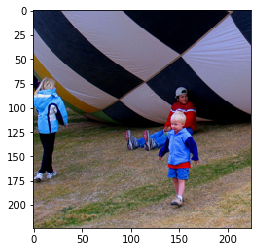

In [13]:
example = data[550]
plt.imshow(np.transpose(example['hr'].numpy(), (1,2,0)))

In [4]:
gen = Generator(3)

dis = Discriminator(3)


## Generator
print(gen)
## Discriminator
print(dis)

Generator(
  (l1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (r1): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
  )
  (r2): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
trainer = Trainer(gen,dis,datal)

In [ ]:
z = torch.randn(10,1,224,224)
out = trainer.generator(z.to(trainer.device))

In [ ]:
out[1].size()

In [14]:
x = False
if x:
    print('j')